In [31]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
print(torch.__version__)
print(torchaudio.__version__)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torch.nn as nn
import torch.nn.functional
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)


2.2.0+cu121
2.2.0+cu121
cuda


In [32]:

class SubsetSC(SPEECHCOMMANDS):
    """
    A class representing a subset of the Speech Commands dataset.

    Args:
        subset (str, optional): The subset to load. Can be one of "validation", "testing", or "training". Defaults to None.
        url (str, optional): The URL to download the dataset from. Defaults to "speech_commands_v0.01".

    Attributes:
        _walker (list): A list of file paths representing the subset.

    """
    def __init__(self, subset: str = None, url="speech_commands_v0.01"): 
        super().__init__("./", url=url, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [33]:
print("length of train_set: ", len(train_set))
print("length of test_set: ", len(test_set))
print("length of valid_set: ", len(valid_set))

length of train_set:  51088
length of test_set:  6835
length of valid_set:  6798


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


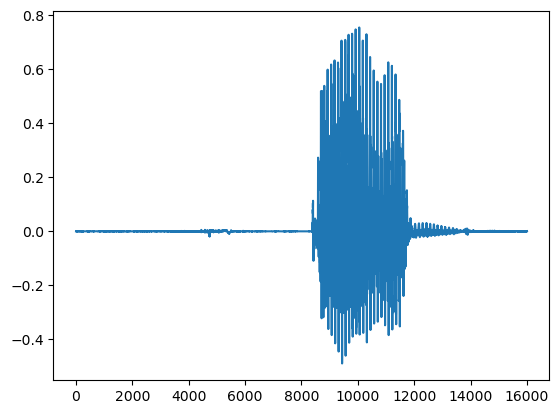

In [34]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

Let’s find the list of labels available in the dataset.

In [35]:
# words = sorted(list(set(datapoint[2] for datapoint in test_set))) # Get the words spoken in the dataset
words = ['bed','bird','cat','dog','down','eight','five','four','go','happy','house','left','marvin','nine','no','off','on','one','right','seven','sheila','six','stop','three','tree','two','up','wow','yes','zero']

We are encoding each word using its index in the list of labels.

In [36]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(words.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return words[index]


# Test 
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(28) --> yes


In [200]:
# extraction des features mfcc

n_fft = 1024 
n_mels = 40
n_mfcc = 40
hop_length = int(0.04 * 16000)  # 40 ms en échantillons
win_length = int(0.03 * 16000)  # 20 ms en échantillons
sample_rate = 16000

# MFCC transform object 
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "win_length": win_length,
        "mel_scale": "htk",
    },
).to(device)
    
# Fonction pour l'augmentation des données
def data_augmentation(waveform, parameters):
    # Time shift perturbation
    if parameters["time_shift"][0]:
        shift_ms = random.uniform(parameters["time_shift"][1][0], parameters["time_shift"][1][1])
        shift_samples = int(sample_rate * shift_ms / 1000)
        waveform = torch.roll(waveform, shifts=shift_samples, dims=-1)

    # Add white noise with magnitude [-90, -46] dB
    if parameters["noise"][0]:
        noise_dB = random.uniform(parameters["noise"][1][0], parameters["noise"][1][1])
        noise_power = torch.pow(10.0, noise_dB / 10)
        noise = torch.randn(waveform.size(), device=device) * noise_power
        waveform += noise

    # Apply SpecAugment
    # 2 continuous time masks of size [0, 25] time steps
    if parameters["time_mask"][0]:
        time_masking = T.TimeMasking(time_mask_param=random.randint(parameters["time_mask"][1][0], parameters["time_mask"][1][1])).to(device)
        waveform = time_masking(waveform)
        waveform = time_masking(waveform)  # Apply twice for 2 continuous time masks

    if parameters["freq_mask"][0]:
        # 2 continuous frequency masks of size [0, 15] frequency bands
        frequency_masking = T.FrequencyMasking(freq_mask_param=random.randint(parameters["freq_mask"][1][0], parameters["freq_mask"][1][1])).to(device)
        waveform = frequency_masking(waveform)
        waveform = frequency_masking(waveform)  # Apply twice for 2 continuous frequency masks
        
    return waveform
        


In [201]:
def extract_mfcc(batch, parameters, augment=False, augment_type="duplicate", type_pad="zero", reshape=False):

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        
        if waveform.size(1) < 16000:
            # Pad the waveform if it is shorter than 1 second
            waveform = torch.nn.functional.pad(waveform, (0, sample_rate - waveform.size(1)), value=0)
        elif waveform.size(1) > 16000:
            # Trim the waveform if it is longer than 1 second
            waveform = waveform[:, :16000]

        # Apply data augmentation to the waveform
        waveform = waveform.to(device)
        if augment:
            if augment_type == "duplicate":
                waveformAug = data_augmentation(waveform, parameters)
            elif augment_type == "random" :
                # dans 30 % des cas on applique l'augmentation
                waveformAug = data_augmentation(waveform, parameters) if random.random() < 0.3 else waveform
            else :
                waveformAug = waveform
            # Apply MFCC transform to the augmented waveform
            waveformAug = mfcc_transform(waveformAug)

            if reshape:
                waveformAug = waveformAug.reshape(1, -1)
            tensors.append(waveformAug)
            targets += [label_to_index(label)]
        
        # Apply MFCC transform to the waveform
        waveform = mfcc_transform(waveform)
        # waveform = waveform.reshape(1, -1)

        tensors.append(waveform)
        targets += [label_to_index(label)]
        
    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)
    return tensors, targets


In [158]:
# implémentation d'un modèle pas très complexe
import copy
class SimpleNeuralNet(nn.Module):
    """
    A simple neural network model for classification tasks.
    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of units in the hidden layer.
        num_classes (int): The number of output classes.
    """
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        """
        Forward pass of the neural network.
        Args:
            x (torch.Tensor): The input tensor.    
        Returns:
            torch.Tensor: The output tensor.
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
# Fonction d'entraînement
def train(model,train_loader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Charger les données sur le GPU
        output = model(data) # Prédiction du modèle
        loss = criterion(output, target) # Calcul de la perte
        optimizer.zero_grad() # Remettre à zéro les gradients
        loss.backward() # Calcul des gradients
        optimizer.step() # Mise à jour des poids
                     
# Fonction d'évaluation
def validation(model, validation_loader, criterion, best_accuracy, best_model, epoch):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct predictions

    accuracy = correct / len(validation_loader.dataset) # Accuracy
    print("epoch: ", epoch, "accuracy: ", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        return copy.deepcopy(model), best_accuracy
    return best_model, best_accuracy

# Fonction de test
def test(model, test_loader): 
    model.eval() # Mettre le modèle en mode évaluation
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return predictions, targets

In [177]:
from functools import partial
from tqdm import tqdm


def global_function(
        model = None,
        optimizer = None,
        criterion = None,
        batch = 256,
        augment_type = "duplicate",
        parameters = None,
        augment = False,
        num_epochs = 10,
        reshape = False,
    ):
    
    batch_size = batch//2 if augment else batch # Batch size for training
    num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

    extract_mfcc_train = partial(extract_mfcc, parameters=parameters, augment=augment, augment_type=augment_type, reshape=reshape)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=extract_mfcc_train, 
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    extract_mfcc_valid = partial(extract_mfcc, parameters=parameters, augment=False)

    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=extract_mfcc_valid,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    # Training function
    best_model = None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs)):
        train(model, train_loader, criterion, optimizer)
        best_model, best_accuracy = validation(model, valid_loader, criterion, best_accuracy, best_model, epoch)
    
    return best_model


In [60]:
model = SimpleNeuralNet(input_size=6464, hidden_size=256, num_classes=30).to(device)
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [True, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}

# Entraînement du modèle
best_model = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    num_epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:16<11:28, 76.54s/it]

epoch:  0 accuracy:  0.44880847308031774


 20%|██        | 2/10 [02:33<10:15, 76.95s/it]

epoch:  1 accuracy:  0.5666372462488968


 30%|███       | 3/10 [03:52<09:04, 77.85s/it]

epoch:  2 accuracy:  0.6097381582818476


 40%|████      | 4/10 [05:12<07:50, 78.42s/it]

epoch:  3 accuracy:  0.6220947337452192


 50%|█████     | 5/10 [06:27<06:26, 77.21s/it]

epoch:  4 accuracy:  0.6206237128567226


 60%|██████    | 6/10 [07:42<05:05, 76.44s/it]

epoch:  5 accuracy:  0.6459252721388644


 70%|███████   | 7/10 [08:57<03:47, 75.97s/it]

epoch:  6 accuracy:  0.6322447778758459


 80%|████████  | 8/10 [10:09<02:29, 74.90s/it]

epoch:  7 accuracy:  0.6312150632538982


 90%|█████████ | 9/10 [11:26<01:15, 75.49s/it]

epoch:  8 accuracy:  0.6290085319211532


100%|██████████| 10/10 [12:42<00:00, 76.20s/it]

epoch:  9 accuracy:  0.6384230656075316


Test Accuracy:  0.6134601316752012
Test Classification Report:
              precision    recall  f1-score   support

         bed       0.56      0.45      0.50       176
        bird       0.63      0.72      0.67       158
         cat       0.52      0.70      0.60       166
         dog       0.46      0.43      0.44       180
        down       0.56      0.51      0.53       253
       eight       0.59      0.70      0.64       257
        five       0.62      0.44      0.52       271
        four       0.75      0.66      0.70       253
          go       0.45      0.34      0.39       251
       happy       0.58      0.85      0.69       180
       house       0.79      0.79      0.79       150
        left       0.68      0.60      0.64       267
      marvin       0.53      0.63      0.58       162
        nine       0.49      0.60      0.54       259
          no       0.41      0.60      0.49       252
         off       0.70      0.61      0.65       262
          on      

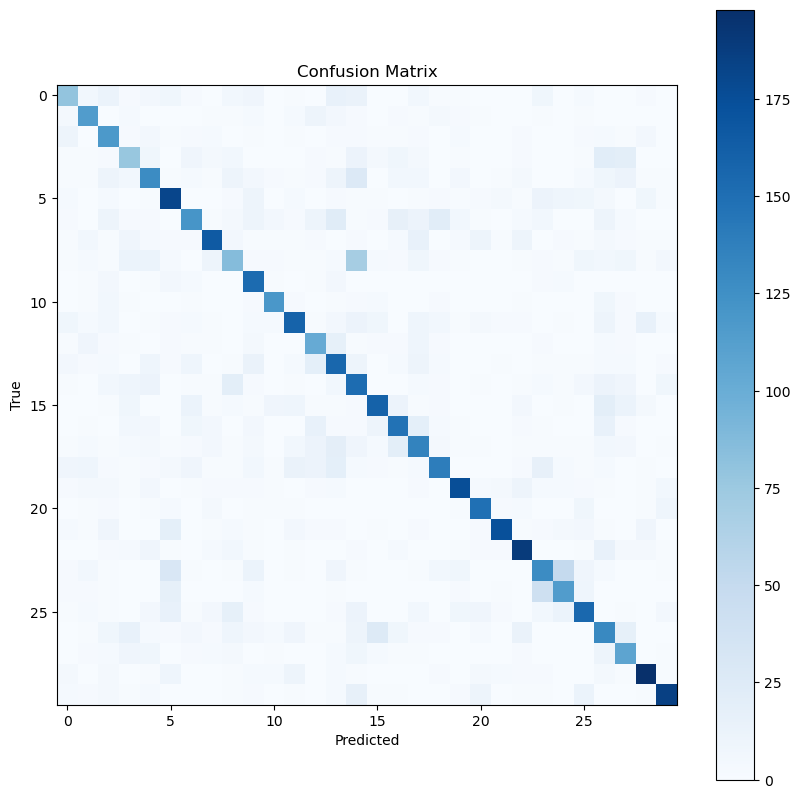

In [72]:
# TEST DU MODELE
from sklearn.metrics import accuracy_score
# Extraction des features MFCC
extract_mfcc_test = partial(extract_mfcc, parameters=parameters, augment=False)

num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_test,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions, targets = test(best_model, test_loader)
print("Test Accuracy: ", accuracy_score(targets, predictions))


# Afficher les performances
print("Test Classification Report:")
print(classification_report(targets, predictions, target_names=words))

# Matrice de confusion
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [70]:
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=6464, hidden_size=500, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_shift = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:03<18:35, 124.00s/it]

epoch:  0 accuracy:  0.4638128861429832


 20%|██        | 2/10 [04:09<16:38, 124.77s/it]

epoch:  1 accuracy:  0.5850250073551044


 30%|███       | 3/10 [06:26<15:11, 130.28s/it]

epoch:  2 accuracy:  0.6212121212121212


 40%|████      | 4/10 [08:30<12:47, 127.95s/it]

epoch:  3 accuracy:  0.6241541629891144


 50%|█████     | 5/10 [10:32<10:29, 125.97s/it]

epoch:  4 accuracy:  0.6251838776110621


 60%|██████    | 6/10 [12:41<08:27, 127.00s/it]

epoch:  5 accuracy:  0.6337157987643425


 70%|███████   | 7/10 [14:52<06:24, 128.11s/it]

epoch:  6 accuracy:  0.6253309796999117


 80%|████████  | 8/10 [16:57<04:14, 127.31s/it]

epoch:  7 accuracy:  0.6070903206825536


 90%|█████████ | 9/10 [19:00<02:05, 125.83s/it]

epoch:  8 accuracy:  0.6423948220064725


100%|██████████| 10/10 [21:02<00:00, 126.29s/it]

epoch:  9 accuracy:  0.6462194763165637


In [83]:
predictions_shift, targets_shift = test(best_model_shift, test_loader)
print("Test Accuracy: ", accuracy_score(targets_shift, predictions_shift))


Test Accuracy:  0.6359912216532553


# Implementation CNN

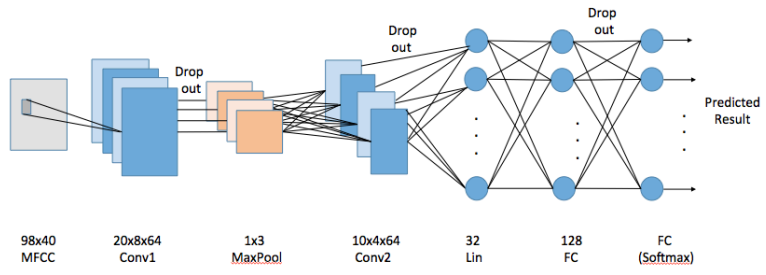

In [223]:
class MFCC_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MFCC_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 3))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding=1)
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=500, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool(x)
        if self.fc1 is None:
            num_features_after_conv = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(in_features=num_features_after_conv, out_features=500).to(x.device)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [224]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
best_model_cnn = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    augment_type="random",
    num_epochs=20,
)

# predictions_cnn, targets_cnn = test(best_model_cnn, test_loader)
# print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))



  0%|          | 0/20 [00:00<?, ?it/s]

In [172]:
extract_mfcc = partial(extract_mfcc, parameters=parameters, augment=False)
test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc,
    num_workers=0,
    pin_memory=False,
)

predictions_cnn, targets_cnn = test(best_model_cnn, test_loader)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))

Test Accuracy:  0.6045354791514265
